In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

import sys
sys.path.append('..')
from clusterizer.algorithms import clusterize_poisson, cluster_boolean_series
from clusterizer.cluster import Cluster
from clusterizer.circuit import MergedCircuit
from clusterizer.plot import draw_location_time_scatter, overlay_cluster
import clusterizer

In [377]:
circuitnr = clusterizer.globals.available_circuits[5]
print(circuitnr)
circuit = MergedCircuit(circuitnr)
circuit.build()
#circuit.pd

2063


In [378]:
#draw_location_time_scatter(circuit)

In [379]:
clusters, bins, bin_contents, rate = clusterize_poisson(circuit)
for cluster in clusters:
    print(cluster)

328m to 364m
256m to 288m
492m to 544m
576m to 628m
0m to 12m


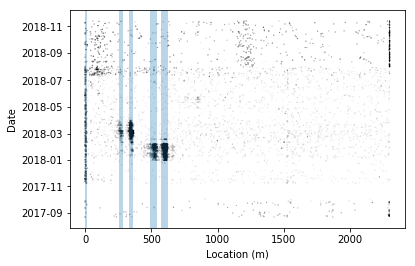

In [380]:
draw_location_time_scatter(circuit, dot_size_to_charge_ratio=1e6)
for cluster in clusters:
    overlay_cluster(cluster)

In [401]:
def bin_times(partial_discharges, bin_size):
    """
    Create a histogram of partial discharges in the time dimension
    """
    time_column = partial_discharges.columns[0]
    convert_times = lambda s: datetime.datetime.strptime(str(s), "%Y-%m-%d %H:%M:%S")
    cluster_times = partial_discharges[time_column].apply(convert_times)
    start_time = cluster_times[cluster_times.index[0]]
    stop_time = cluster_times[cluster_times.index[-1]]
    bins = np.arange(start = start_time, stop = stop_time, step = bin_size)
    binned_pds, _ = np.histogram(cluster_times, bins=bins)
    return binned_pds, bins

def pds_in_cluster(partial_discharges, cluster):
    xmin = cluster.location_range[0]
    xmax = cluster.location_range[1]
        
    location_column = partial_discharges.columns[1]
    in_cluster = [xmin <= loc <= xmax for loc in partial_discharges[location_column]]
    cluster_pds = partial_discharges[in_cluster]
    return cluster_pds
    
def time_clustering(circuit, clusters, bin_size = datetime.timedelta(days=1)):
    time_column, location_column, charge_column = circuit.pd.columns
    pardis = circuit.pd[circuit.pd_occured]
    
    result = []
    
    for cluster in clusters:
        cluster_pds = pds_in_cluster(pardis, cluster)
        
        binned_pds, bins = bin_times(cluster_pds, bin_size)
        average = np.mean(binned_pds)
        print(str(cluster) + ": " + str(average))
        print(binned_pds)
        
        boolean_pds_fault = binned_pds > average
        index_time_cluster_edges = cluster_boolean_series(boolean_pds_fault)
        for index_time_cluster in index_time_cluster_edges:
            tmin = bins[index_time_cluster[0]]
            tmax = bins[index_time_cluster[1]]
            location_time_cluster = Cluster(location_range=cluster.location_range, time_range=(tmin, tmax))
            result.append(location_time_cluster)
    return result

In [402]:
time_clusters = time_clustering(circuit, clusters)
for cluster in time_clusters:
    print(cluster)

328m to 364m: 4.9811764705882355
[  1   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0
   0   1   0   0   0   0   0   0   0   0   1   0   0   0   1   0   0   0
   1   0   0   0   0   0   0   0   0   0   0   0   2   0   0   0   0   0
   2   0   0   0   0   0   0   0   0   0   0   1   1   2   4   2   2   0
   1   0   1   0   1   9   5   8   5   5   1   3   1   0   1   0   1   0
   0   1   2   5   0   0  13  20  23   0   2   2   5  11  10  14  10  22
  21  25  35  35  46  46  30  29  62  56 147  97  40  93 211 153 160  45
  20  43  34  21  37  46  19  12  11  36  80  40  34  16   3  33  22   4
   8   6  13   3   0   3   0   0   1   2   0   0   0   0   0   1   1   0
   0   0   0   1  

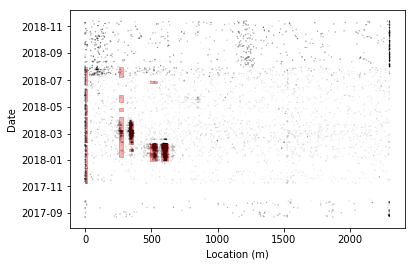

In [387]:
draw_location_time_scatter(circuit, dot_size_to_charge_ratio=1e6)
for cluster in time_clusters:
    overlay_cluster(cluster, color='r')

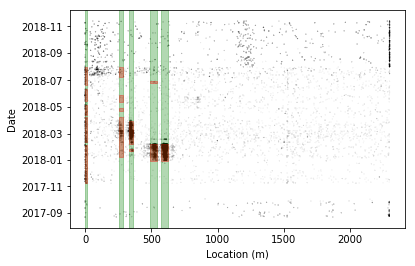

In [388]:
draw_location_time_scatter(circuit, dot_size_to_charge_ratio=1e6)
for cluster in clusters:
    overlay_cluster(cluster, color='g')
for cluster in time_clusters:
    overlay_cluster(cluster, color='r')

# Een aantal plot dingen

Histogram in de tijd-dimensie en een algemenere functie waarbij je ook kan zeggen dat je de histogram gesorteerd wil hebben naar aantal pds per bakje.

In [ ]:
def draw_time_hist(circuit, partial_discharges=None, weigh_charges=False, ax=None, bins=None, color='black'):
    if ax is None:
        ax = plt.gca()
    if partial_discharges is None:
        partial_discharges = circuit.pd
    time_column, location_column, charge_column = circuit.pd.columns
    convert_times = lambda s: datetime.datetime.strptime(str(s), "%Y-%m-%d %H:%M:%S")
    times = partial_discharges[time_column].apply(convert_times)
    if bins is None: 
        start_time = times[times.index[0]]
        stop_time = times[times.index[-1]]
        bins = np.arange(start = start_time, stop = stop_time, step = datetime.timedelta(days=1))
    hist_weights = None
    if weigh_charges:
        hist_weights = partial_discharges[charge_column]
    
    counts, _, _ = ax.hist(times, weights=hist_weights, bins=len(bins), color=color, label="Circuit {0}".format(circuit.circuitnr))
    ax.set_xlabel("Time")
    ax.set_ylabel("Number of PDs")
    

def draw_bar_graph(circuit, partial_discharges=None, weigh_charges=False, ax=None, bins=None, sort_hist=False, color='black'):
    if ax is None:
        ax = plt.gca()
    if partial_discharges is None:
        partial_discharges = circuit.pd
    time_column, location_column, charge_column = circuit.pd.columns
    convert_times = lambda s: datetime.datetime.strptime(str(s), "%Y-%m-%d %H:%M:%S")
    times = partial_discharges[time_column].apply(convert_times)
    if bins is None: 
        start_time = times[times.index[0]]
        stop_time = times[times.index[-1]]
        bins = np.arange(start = start_time, stop = stop_time, step = datetime.timedelta(days=1))
    hist_weights = None
    if weigh_charges:
        hist_weights = partial_discharges[charge_column]
        
    hist, bins = np.histogram(times, bins, weights=hist_weights)
    width = 1
        
    if sort_hist:
        hist = sorted(hist)
        center = np.arange(0, 100, 100/len(hist))
        ax.bar(center, hist, align='center', width=width, color=color)
        ax.set_xlabel("Percentile")
    else:
        bins_conv = np.array(list(map(convert_times, list(map(pd.Timestamp, bins)))))
        delta = (bins[:-1] - bins[1:])/2
        center = bins[1:] + delta
        ax.bar(center, hist, align='center', width=width, color=color)
        ax.set_xlabel("Time")
    ax.set_ylabel("Number of PDs")

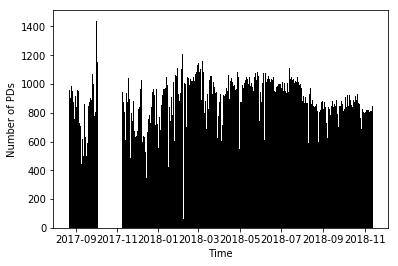

In [397]:
draw_time_hist(circuit)

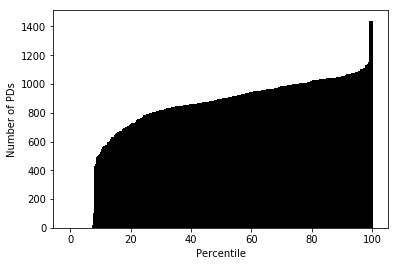

In [398]:
draw_bar_graph(circuit, sort_hist=True)

576m to 628m


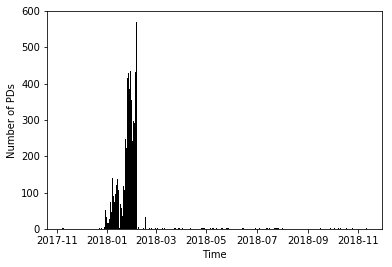

In [399]:
cluster_list = list(clusters)
cur_clust = cluster_list[3]
print(cur_clust)
cluster_pds = pds_in_cluster(circuit.pd, cur_clust)

draw_time_hist(circuit, partial_discharges=cluster_pds)

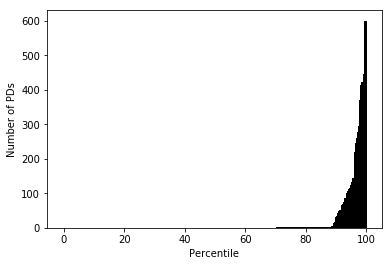

In [400]:
draw_bar_graph(circuit, partial_discharges=cluster_pds, sort_hist=True)